In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from torch import nn, Tensor
import time
plt.style.use('seaborn-v0_8')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

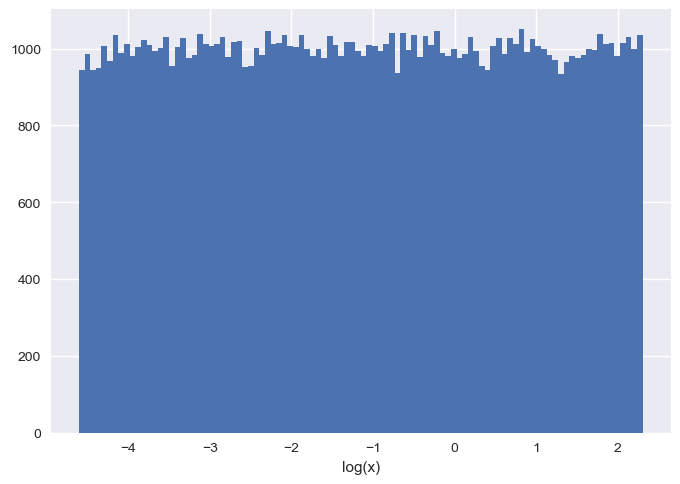

In [2]:
def sample_log_uniform(low, high, size, device=None):
    """
    low, high: scalars (floats), low > 0
    size: tuple, e.g. (B,)
    """
    u = torch.rand(size, device=device)
    log_low = torch.log(torch.tensor(low, device=device))
    log_high = torch.log(torch.tensor(high, device=device))
    return torch.exp(log_low + u * (log_high - log_low))


def sample_prior(B, device=None):
    gamma = sample_log_uniform(0.05, 0.5, (B, 1), device)
    R0 = sample_log_uniform(0.5, 5.0, (B, 1), device)
    beta = R0 * gamma
    return torch.cat([beta, gamma], dim=1)

samples = sample_log_uniform(0.01, 10.0, (100_000,))
plt.hist(torch.log(samples).numpy(), bins=100)
plt.xlabel("log(x)")
plt.show()

tensor([[0.8288, 0.1953],
        [0.3476, 0.0754]])


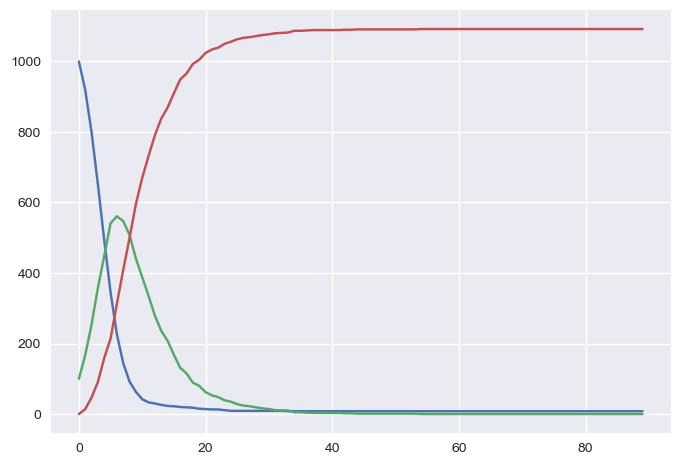

In [3]:
def simulate(phi, sir, T):
    S, I, R = sir
    S = torch.zeros(phi.shape[0], device=phi.device) + S
    I = torch.zeros(phi.shape[0], device=phi.device) + I
    R = torch.zeros(phi.shape[0], device=phi.device) + R
    N = S + I + R
    states = torch.zeros(phi.shape[0], T, 3, device=phi.device)
    for t in range(0, T):
        states[:, t, 0] = S
        states[:, t, 1] = I
        states[:, t, 2] = R

        p_inf = 1 - torch.exp(-phi[:, 0] * I / N)
        p_rec = 1 - torch.exp(-phi[:, 1])

        new_inf = torch.binomial(S, p_inf)
        new_rec = torch.binomial(I, p_rec)

        S = S - new_inf
        I = I + new_inf - new_rec
        R = R + new_rec

    states[:, T-1, 0] = S
    states[:, T-1, 1] = I
    states[:, T-1, 2] = R
    return states        
    
sir = (1000, 100, 0)
# phi = torch.tensor([[5, 5],
#                     [10, 5]])
phi = sample_prior(2)
print(phi)
x_0, x_1 = simulate(phi, sir, 90).cpu()
S, I, R = x_0[:, 0], x_0[:, 1], x_0[:, 2]
plt.plot(S)
plt.plot(I)
plt.plot(R)
# S, I, R = x_1[:, 0], x_1[:, 1], x_1[:, 2]
# plt.plot(S)
# plt.plot(I)
# plt.plot(R)

torch.Size([2, 90, 3]) torch.Size([2, 5])


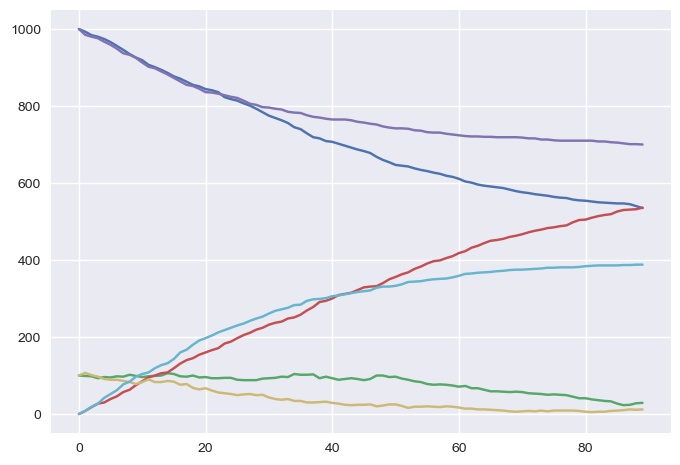

In [4]:
def summary(x):
    S, I, R = x[:, :, 0], x[:, :, 1], x[:, :, 2]
    I_peak, t_peak = I.max(dim=1)

    t_peak = t_peak / S.shape[1]
    t_peak = torch.transpose(t_peak.expand(1, t_peak.shape[0]), 0, 1)
    
    I_peak_norm = I_peak / I.sum(dim=1)
    I_peak_norm = torch.transpose(I_peak_norm.expand(1, I_peak_norm.shape[0]), 0, 1)

    I_integral = (I / I[:, 0, None]).sum(dim=1) / I.shape[1]
    I_integral = torch.transpose(I_integral.expand(1, I_integral.shape[0]), 0, 1)

    R_final = R[:, -1] / R.sum(dim=1)
    R_final = torch.transpose(R_final.expand(1, R_final.shape[0]), 0, 1)

    S_final = S[:, -1] / S.sum(dim=1)
    S_final = torch.transpose(S_final.expand(1, S_final.shape[0]), 0, 1)


    return torch.cat([t_peak, I_peak_norm, I_integral, R_final, S_final], dim=1)

phi = sample_prior(2)
x = simulate(phi, sir, 90)
print(x.shape, summary(x).shape)
# print(summary(x))
# bull = False
# for i in range(x.shape[0]):
#     if bull:
#         break
#     for j in range(i+1, x.shape[0]):
#         if abs(summary(x)[i, 0:2] - summary(x)[j, 0:2]).sum() + abs(summary(x)[i, 3] - summary(x)[j, 3]) < 0.01:
#             for k in [i, j]: 
#                 S, I, R = x[k, :, 0], x[k, :, 1], x[k, :, 2]
#                 plt.plot(S)
#                 plt.plot(I)
#                 plt.plot(R)
#             bull = True
#             break

for i in range(x.shape[0]):
    S, I, R = x[i, :, 0], x[i, :, 1], x[i, :, 2]
    plt.plot(S)
    plt.plot(I)
    plt.plot(R)

0
1
3
4
6
7
10
13
13
14
14
16
17
19
20
22
22
24
26
26
27
31
33
34
36
38
38
40
41
42
44
44
45
46
48
48
51
53
54
55
56
57
57
58
59
60
61
61
62
64
64
66
69
72
72
72
73
74
75
78
80
81
81
81
81
83
85
85
85
86
87
90
91
91
92
93
93
94
95
97
99
100
100
104
105
105
105
106
107
108
108
109
110
111
113
115
116
117
119
120
120
120
121
122
123
123
124
124
127
128
128
129
131
132
133
135
135
137
137
138
140
143
145
146
149
151
152
153
154
156
160
160
161
161
162
163
164
165
168
168
169
171
171
171
172
174
174
174
177
180
180
181
182
184
185
185
187
189
190
191
191
192
193
194
195
195
196
196
198
198
199
199
200
201
204
206
208
210
210
210
210
212
213
214
215
216
217
218
219
220
221
221
223
226
227
228
229
231
234
234
235
237
239
240
240
240
243
243
245
245
245
246
246
247
248
249
252
253
259
260
261
264
264
264
264
265
267
268
268
269
269
272
273
273
274
275
275
275
276
276
276
278
281
282
282
282
283
284
285
286
286
289
290
292
295
296
298
300
302
303
305
307
309
309
311
312
312
313
314
314
316
317

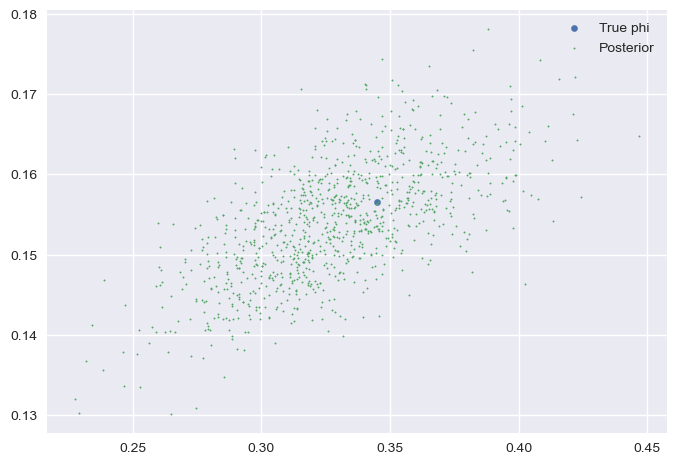

In [5]:
def ABC(s, num_samples, sim_parameters, n=1000, eps=1e-2):
    sir = sim_parameters["sir"]
    T = sim_parameters["T"]
    
    samples = []
    c = 0
    while c < num_samples: 
        phi_0 = sample_prior(n)
        x_0 = simulate(phi_0, sir, T)
        s_0 = summary(x_0)
        samp = phi_0[torch.where(abs(s - s_0).sum(dim=-1) < eps)]
        c += len(samp)
        samples.append(samp)
        print(c)
    return torch.cat(samples, dim=0)[:num_samples]


sir = (1000, 100, 0)
T = 90
sim_parameters = {
    "sir": sir,
    "T": T
}
phi = sample_prior(1)
x = simulate(phi, sir, T)
s = summary(x)

phi_pred = ABC(s, 1000, sim_parameters, n=10000, eps=1e-2)
plt.scatter(phi[:, 0], phi[:, 1], s=20, label="True phi")
plt.scatter(phi_pred[:, 0], phi_pred[:, 1], s=1, label="Posterior")
plt.legend()

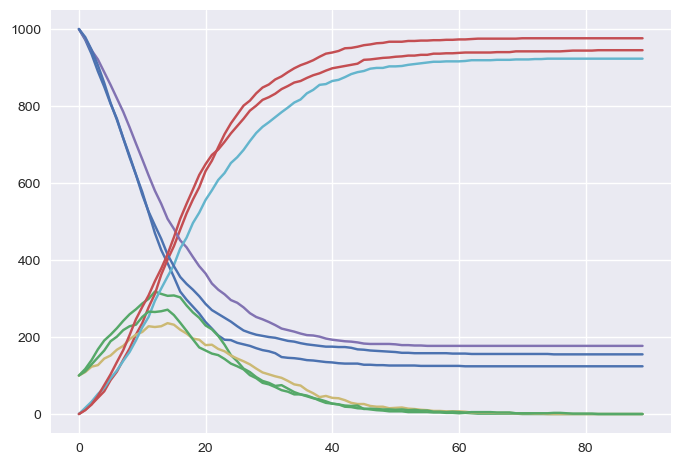

In [6]:
x_pred = simulate(phi_pred, sir, 90)
s_pred = summary(x_pred)
phi_pred_1 = phi_pred[torch.where(abs(s_pred - s).sum(dim=-1) < 4e-3)] 
x_pred_1 = simulate(phi_pred_1, sir, 90)

for i in range(x_pred_1.shape[0]):
    S, I, R = x_pred_1[i, :, 0], x_pred_1[i, :, 1], x_pred_1[i, :, 2]
    plt.plot(S)
    plt.plot(I)
    plt.plot(R)